In [4]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt
import torch 
from infopath.utils.functions import run_with_perturbation
import os
from infopath.utils.plot_utils import plot_with_size, strip_right_top_axis
import numpy as np
import random 
%reload_ext autoreload
%autoreload 2
font = {"size": 6, "family":"arial"}
import matplotlib

matplotlib.rc("font", **font)
matplotlib.rcParams["pdf.fonttype"] = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# set seed for reproducibility
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True

In [3]:
os.chdir("..")

In [ ]:
trials = 100
dt = 0.001
size = 16
teacher_nofb = "log_dir/1d74764c4551eef5158418ea67fbe1a5885dfdb1/2024_5_27_9_46_33_teacher_conf_block/"
opt = load_training_opt(teacher_nofb)
opt.device = DEVICE
m_teacher_nofb = load_model_and_optimizer(opt, reload=True, last_best="best")[0]


teacher_withfb = "log_dir/1d74764c4551eef5158418ea67fbe1a5885dfdb1/2024_5_27_9_46_33_teacher_conf/"
torch.cuda.empty_cache()
opt = load_training_opt(teacher_withfb)
opt.device = DEVICE
m_teacher_withfb = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
m_teacher_withfb.rsnn.decay_v = torch.exp(-opt.dt / m_teacher_withfb.rsnn.tau)

area_index = m_teacher_withfb.rsnn.area_index
excitatory_index = m_teacher_withfb.rsnn.excitatory_index

In [5]:
@torch.no_grad()
def run(model, trials=400, thr=7, seed=0):
    stims = torch.ones(trials)*4 
    torch.manual_seed(seed)
    spikes = model(stims)[0]
    filt = model.filter_fun2(model.filter_fun1(spikes))
    area0_active = (
        filt[:, :, model.rsnn.area_index == 0].mean((2)).max(0)[0] / model.timestep
        > thr
    )
    area1_active = (
        filt[:, :, model.rsnn.area_index == 1].mean((2)).max(0)[0] / model.timestep
        > thr
    )
    trial_type = area0_active * 2 + area1_active
    return spikes, model.filter_fun1(spikes), trial_type


def psth_plot(filt, filt1, trial_type, trial_type1, area_index, ax, area=0, dt=0.001, start=-0.048, stop=0.152, neurons_show=-1):
    time = torch.arange(0, filt.shape[0])/filt.shape[0] *(stop-start) + start
    neurons_show = area_index == area if neurons_show == -1 else (area_index == area) & (excitatory_index == neurons_show)
    ax.axvline(0, color="gold")
    ax.plot(time, filt[:, :, neurons_show][:,trial_type<=1].mean((1,2)).cpu()/dt, color="orange", alpha=0.7, linewidth=1)
    ax.plot(time, filt[:, :, neurons_show][:,trial_type==3].mean((1,2)).cpu()/dt, color="blue", alpha=0.7, linewidth=1)
    ax.axvline(0, color="gold")
    ax.plot(time, filt1[:, :, neurons_show][:,trial_type1<=1].mean((1,2)).cpu()/dt, color="red", alpha=0.7, linewidth=1)
    ax.plot(time, filt1[:, :, neurons_show][:,trial_type1==3].mean((1,2)).cpu()/dt, color="green", alpha=0.7, linewidth=1)
    ax.set_ylim(0, 21)
    return ax

def spike_plot(spikes, trial_type, area_index, ax, area=0, dt=0.001, start=-0.048, trial=0):
    ax.axvline(0, color="gold")
    hit_trial = torch.where(trial_type==3)[0][trial]
    tms, neurons = torch.where(spikes[:, hit_trial, area_index == area].cpu() > 0)
    color = ["red" if i else "black" for i in (neurons >= 200)]
    ax.scatter(tms*dt+start, neurons, marker="|", s=2, c=color, linewidth=0.5)
    strip_right_top_axis(ax)    
    return ax



In [6]:
area = 1
exc = 0
power = 0
torch.manual_seed(0)
filt_nofb, trial_type_nofb, _, spikes_nofb = run_with_perturbation(m_teacher_nofb, trials=trials, area=area, exc=exc, power=power)
filt_withfb, trial_type_withfb, _, spikes_withfb = run_with_perturbation(m_teacher_withfb, trials=trials, area=area, exc=exc, power=power)
filt_nofb = m_teacher_nofb.filter_fun1(spikes_nofb)
filt_withfb = m_teacher_withfb.filter_fun1(spikes_withfb)

area = 1
exc = 0
power = 1
torch.manual_seed(0)
filt_nofb_light, trial_type_nofb_light, _, spikes_nofb_light = run_with_perturbation(m_teacher_nofb, trials=trials, area=area, exc=exc, power=power)
filt_withfb_light, trial_type_withfb_light, _, spikes_withfb_light = run_with_perturbation(m_teacher_withfb, trials=trials, area=area, exc=exc, power=power)

area = 1
exc = 1
power = 0.08
torch.manual_seed(0)
filt_nofb_light_act, trial_type_nofb_light_act, _, spikes_nofb_light_act = run_with_perturbation(m_teacher_nofb, trials=trials, area=area, exc=exc, power=power)
filt_withfb_light_act, trial_type_withfb_light_act, _, spikes_withfb_light_act = run_with_perturbation(m_teacher_withfb, trials=trials, area=area, exc=exc, power=power)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


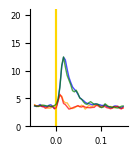

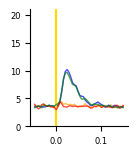

In [7]:
fig1, ax1 = plot_with_size(25, 30)
strip_right_top_axis(ax1) 
psth_plot(filt_nofb, filt_withfb, trial_type_nofb, trial_type_withfb, area_index, ax1, area=0)
fig1.savefig("FiguresOpto/Supplementary_Figure0/Figure1D_area1_control.pdf", transparent=True)


fig1, ax1 = plot_with_size(25, 30)
strip_right_top_axis(ax1) 
psth_plot(filt_nofb, filt_withfb, trial_type_nofb, trial_type_withfb, area_index, ax1, area=1)
fig1.savefig("FiguresOpto/Supplementary_Figure0/Figure1D_area2_control.pdf", transparent=True)


tensor(0.7249) tensor(1.2706)


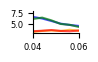

In [8]:
# zoom window
time = torch.arange(0, filt_nofb.shape[0])/filt_nofb.shape[0] *(opt.stop-opt.start) + opt.start
fig1, ax1 = plot_with_size(12, 6)
ax1.axvline(0, color="gold")
strip_right_top_axis(ax1)    
sig1 = filt_nofb[:, :, area_index == 0][:,trial_type_nofb==0].mean((1,2)).cpu()/dt
sig2 = filt_nofb[:, :, area_index == 0][:,trial_type_nofb==3].mean((1,2)).cpu()/dt
ax1.plot(time, sig1, color="orange", alpha=0.7)
ax1.plot(time, sig2, color="blue", alpha=0.7)
ax1.axvline(0, color="gold")
strip_right_top_axis(ax1)    
sig1_with = filt_withfb[:, :, area_index == 0][:,trial_type_withfb==0].mean((1,2)).cpu()/dt
sig2_with = filt_withfb[:, :, area_index == 0][:,trial_type_withfb==3].mean((1,2)).cpu()/dt
ax1.plot(time, filt_withfb[:, :, area_index == 0][:,trial_type_withfb==0].mean((1,2)).cpu()/dt, color="red", alpha=0.7)
ax1.plot(time, filt_withfb[:, :, area_index == 0][:,trial_type_withfb==3].mean((1,2)).cpu()/dt, color="green", alpha=0.7)
ax1.set_ylim(3, 8)
ax1.set_xlim(0.04, 0.06)
fig1.savefig("FiguresOpto/Supplementary_Figure0/zoom.pdf", transparent=True)
print((sig1-sig1_with).abs().max(), (sig2-sig2_with).abs().max())

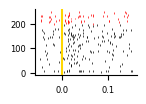

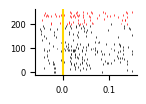

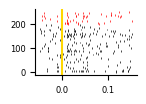

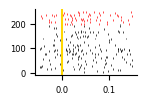

In [9]:
fig, ax = plot_with_size(26, 17)
spike_plot(spikes_nofb, trial_type_nofb, area_index, ax, area=0, trial=0)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1B_area1.pdf")

fig, ax = plot_with_size(26, 17)
spike_plot(spikes_nofb, trial_type_nofb, area_index, ax, area=1, trial=0)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1B_area2.pdf")


fig, ax = plot_with_size(26, 17)
spike_plot(spikes_withfb, trial_type_withfb, area_index, ax, area=0, trial=13)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1C_area1.pdf")

fig, ax = plot_with_size(26, 17)
spike_plot(spikes_withfb, trial_type_withfb, area_index, ax, area=1, trial=13)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1C_area2.pdf")

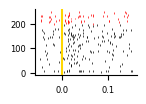

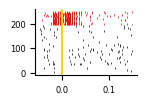

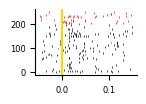

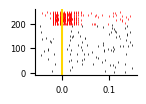

In [10]:
fig, ax = plot_with_size(26, 17)
spike_plot(spikes_nofb_light, trial_type_nofb_light, area_index, ax, area=0, trial=0)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1B_area1_inact.pdf")

fig, ax = plot_with_size(26, 17)
spike_plot(spikes_nofb_light, trial_type_nofb_light, area_index, ax, area=1, trial=0)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1B_area2_inact.pdf")


fig, ax = plot_with_size(26, 17)
spike_plot(spikes_withfb_light, trial_type_withfb_light, area_index, ax, area=0, trial=13)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1C_area1_inact.pdf")

fig, ax = plot_with_size(26, 17)
spike_plot(spikes_withfb_light, trial_type_withfb_light, area_index, ax, area=1, trial=13)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1C_area2_inact.pdf")

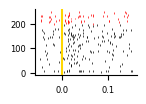

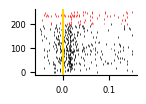

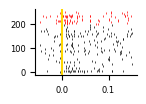

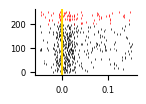

In [11]:
fig, ax = plot_with_size(26, 17)
spike_plot(spikes_nofb_light_act, trial_type_nofb_light_act, area_index, ax, area=0, trial=0)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1B_area1_act.pdf")

fig, ax = plot_with_size(26, 17)
spike_plot(spikes_nofb_light_act, trial_type_nofb_light_act, area_index, ax, area=1, trial=0)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1B_area2_act.pdf")


fig, ax = plot_with_size(26, 17)
spike_plot(spikes_withfb_light_act, trial_type_withfb_light_act, area_index, ax, area=0, trial=13)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1C_area1_act.pdf")

fig, ax = plot_with_size(26, 17)
spike_plot(spikes_withfb_light_act, trial_type_withfb_light_act, area_index, ax, area=1, trial=13)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1C_area2_act.pdf")


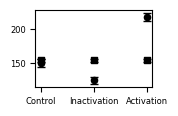

In [12]:
import pandas as pd
fig, ax = plot_with_size(30, 20)

data = pd.DataFrame(columns=("spike_count_mean", "spike_count_std", "structure", "light"))
for light, spikes in zip([-1, 0, 1], [spikes_nofb, spikes_nofb_light, spikes_nofb_light_act]):
    spike_count = (spikes[50:150, trial_type_nofb==3][:, :, area_index==0].cpu().numpy().sum((0,2)).mean())
    # spike_count_std = spikes[:, trial_type_nofb==3][:, :, area_index==0].cpu().numpy().sum((0,2)).std()
    # spike count 95% confidence interval
    spike_count_std = 1.96 * spikes[50:150, trial_type_nofb==3][:, :, area_index==0].cpu().numpy().sum((0,2)).std() / (trials**0.5)
    entry = {"spike_count_mean":spike_count, "structure":"nofb", "light":light, "spike_count_std":spike_count_std}
    data = pd.concat([data, pd.DataFrame(entry, index=[0])], ignore_index=True)

for light, spikes in zip([-1, 0, 1], [spikes_withfb, spikes_withfb_light, spikes_withfb_light_act]):
    spike_count = spikes[50:150, trial_type_withfb==3][:, :, area_index==0].cpu().numpy().sum((0,2)).mean()
    spike_count_std = 1.96 * spikes[50:150, trial_type_nofb==3][:, :, area_index==0].cpu().numpy().sum((0,2)).std() / (trials**0.5)
    entry = {"spike_count_mean":spike_count, "structure":"withfb", "light":light, "spike_count_std":spike_count_std}
    data = pd.concat([data, pd.DataFrame(entry, index=[0])], ignore_index=True)
# with nofb with marker square, withfb with marker circle
for i, row in data.iterrows():
    ax.scatter(row["light"], row["spike_count_mean"], marker="s" if row["structure"] == "nofb" else "o", c="black", s=20)
# errorbar with sem and caps
ax.errorbar(data["light"].values, data["spike_count_mean"].values, yerr=data["spike_count_std"].values, fmt="none", ecolor="black", capsize=3)
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(["Control", "Inactivation", "Activation"])
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1D.pdf", transparent=True)


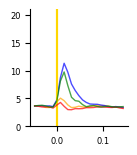

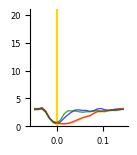

In [13]:
import pandas as pd

fig, ax = plot_with_size(25, 30)
strip_right_top_axis(ax) 
psth_plot(filt_nofb_light, filt_withfb_light, trial_type_nofb_light, trial_type_withfb_light, area_index, ax, area=0)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1D_area1_inact.pdf", transparent=True)


fig, ax = plot_with_size(25, 30)
strip_right_top_axis(ax) 
psth_plot(filt_nofb_light, filt_withfb_light, trial_type_nofb_light, trial_type_withfb_light, area_index, ax, area=1, neurons_show=1)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1D_area2_inact.pdf", transparent=True)

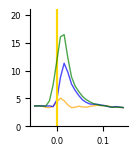

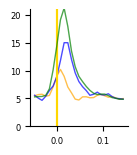

In [14]:
import pandas as pd

fig, ax = plot_with_size(25, 30)
strip_right_top_axis(ax) 
psth_plot(filt_nofb_light_act, filt_withfb_light_act, trial_type_nofb_light_act, trial_type_withfb_light_act, area_index, ax, area=0)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1D_area1_act.pdf", transparent=True)


fig, ax = plot_with_size(25, 30)
strip_right_top_axis(ax) 
psth_plot(filt_nofb_light_act, filt_withfb_light_act, trial_type_nofb_light_act, trial_type_withfb_light_act, area_index, ax, area=1, neurons_show=0)
fig.savefig("FiguresOpto/Supplementary_Figure0/Figure1D_area2_act.pdf", transparent=True)